## Leveraging ML to facilitate Plastic Pollution Cleanup in Water Bodies

This study will focus on how Machine Learning technology can be used to help in detecting plastic in water bodies using satellite and drone images, so that cleanup efforts are deployed in right location with right resources.

*Object detection* is a deep learning approach which localizes and simultaneously classify different objects present in a digital image. Object detection technique draws bounding boxes on the objects and also categorize the class of such objects at the same time. Object detection technique will best suitable for this study because the goal is to identify the exact location of plastic waste only if present in digital images.

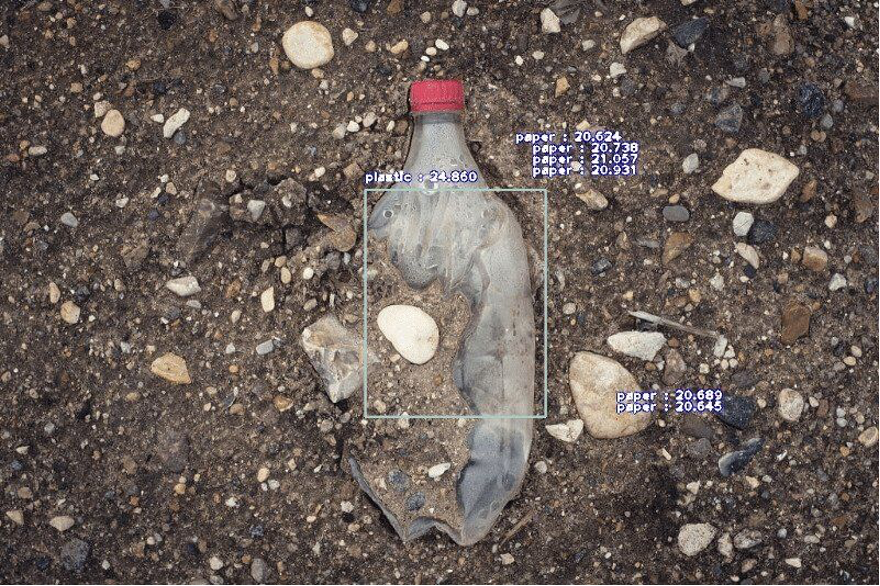

### Datasets

The dataset identified for this study is taken from [Data Repository][1] for the University of Minnesota (DRUM).  The dataset contains images of various different kinds of marine debris that are captured from real underwater environments where the objects are in different states of decay, occlusion, and overgrowth. The images are labeled with bounding boxes on instances of trash, biological objects such as plants and animals, and ROVs (Fulton et al., 2020).

[1]:https://conservancy.umn.edu/handle/11299/214366

### Data Exploration

The dataset is avaibale a a zip archive containing `train`, `val` and `test` directories. Each directory contain images in jpeg format and also a corresponding text file that contains the bounding box coordinates and classes of the obejects present in the image. YOLO object detection model will be used in this study needs the bounding boxes to be in [YOLO][1] format for training.

Lets explore if the labelled text in correct YOLO format.

[1]: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format

In [1]:
# import required libraries
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
from ultralytics.utils.ops import xywhn2xyxy,xywh2xyxy
import shutil

In [4]:
# Helper function to plot an image in the notebook
def plot_image(img):
    dpi = 80
    imgWidth,imgHeight,_ = img.shape
    figsize = imgWidth / float(dpi), imgHeight / float(dpi)    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

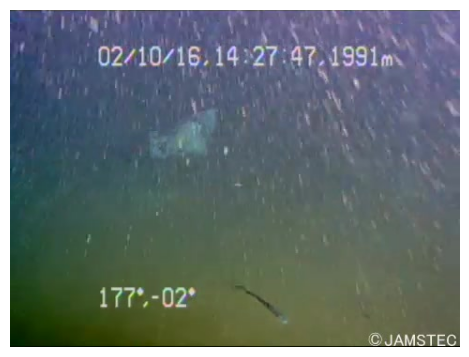

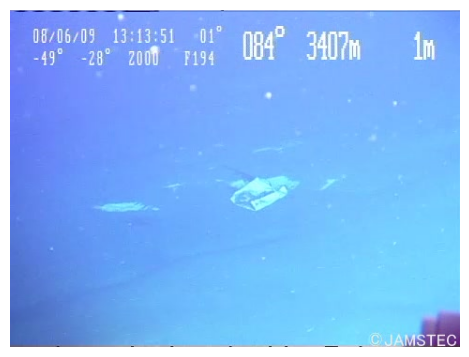

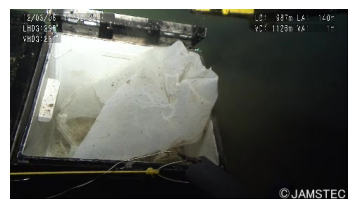

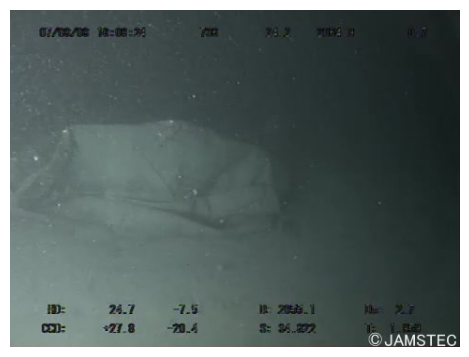

In [4]:
# Display few images from training directory
image_file_names = []
for files in os.listdir("./dataset/train")[0:10]:
    if (files.split(".")[-1] == "jpg") or (files.split(".")[-1] == "png"):
        img = cv2.imread(os.path.join("./dataset/train/",files))
        plot_image(img)
        image_file_names.append(os.path.join("./dataset/train/",files.split(".")[0]))

We see that the images represent underwater images containing plastic debris and other unwanted as expected. There should be also bounding box coordinates in text with the same filename as the image file in the training directory. Lets use the bounding boxe coordinate file to draw th boxes for the training images. The classes of the objects in the bounding boxes are numbered in the dataset as follows:

- 0: Plastic Trash
- 1: Biological Life (Animals, fishes, etc)
- 3: ROV (Parts of the Remotely Operated Vehical used to capture the images)

In [10]:
def draw_label (image, box, conf, label):
    bbox = np.array(box).astype(np.int32)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), [255,0,0], 2, cv2.LINE_AA)
    cv2.putText(image, "{}:{}".format(label,str(conf)[0:4]), (bbox[0], bbox[1] - 10),  0, 1e-3 * imgHeight, [255,0,0], 2)
    
def resize_bb(old, new, min_b, max_b):
    old = np.array(old)
    new = np.array(new)
    min_b = np.array(min_b)
    max_b = np.array(max_b)
    min_xy = min_b/(old/new)
    max_xy = max_b/(old/new)
    return [int(min_xy[0]),int(min_xy[1]),int(max_xy[0]),int(max_xy[1])]


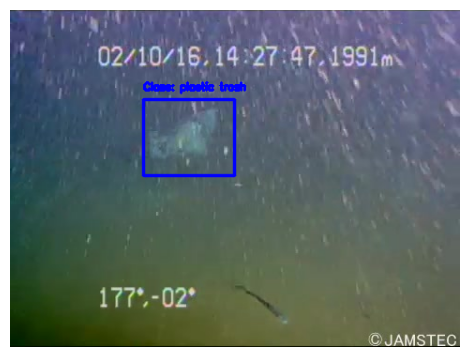

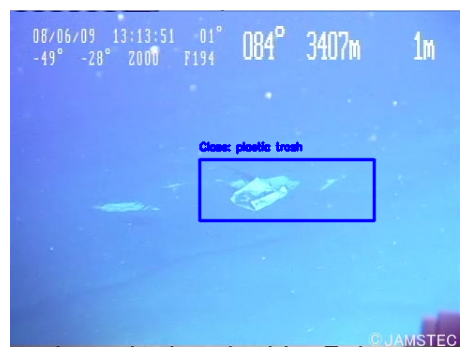

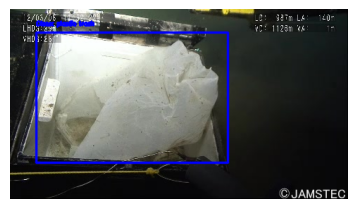

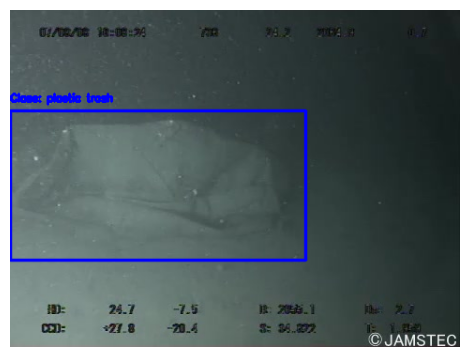

In [7]:
#display images with bounding box coordinates from ground truth label file
class_labels = {0:"plastic trash", 1:"Bio Life", 3:"ROV"}

for files in image_file_names:
    img = cv2.imread(f"{files}.jpg")
    imgHeight,imgWidth,_ = img.shape
    
    with open(f"{files}.txt", "r") as label:
        records = label.readlines()
        for record in records:            
            unpacked_list = [float(i) for i in record.split()]
            xywh_boxes = np.array(unpacked_list[1:])
            xyxy = xywhn2xyxy(xywh_boxes,img.shape[1], img.shape[0])
            xyxy = xyxy.astype("int32")
            cv2.rectangle(img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), [255,0,0], 2, cv2.LINE_AA)
            cv2.putText(img, f"Class: {class_labels[int(unpacked_list[0])]}", (xyxy[0], xyxy[1] - 10),  0, 1e-3 * imgHeight, [255,0,0], 2)

    plot_image(img)

### Data prepration

The label text file and image are both needed for training. The images and labelled text file needed to be in separate directories as shown in below hierarchy for use in YOLO.

- images
  - train
  - val
  - test
- labels
  - train
  - val
  - test


In [10]:
# this function separtes the image and label text files in separate dirctories
def arrange_dir_for_yolo(dirname):
    image_count = 0
    label_count = 0
    print(f"setting up files for {dirname}")
    if os.path.exists(os.path.join("./yolo_dataset/images/", dirname)):
        shutil.rmtree(os.path.join("./yolo_dataset/images/", dirname))
    else:
        os.makedirs(os.path.join("./yolo_dataset/images/", dirname))
        
    if os.path.exists(os.path.join("./yolo_dataset/labels/", dirname)):
        shutil.rmtree(os.path.join("./yolo_dataset/labels/", dirname))
    else:
        os.makedirs(os.path.join("./yolo_dataset/labels/", dirname))
        
    for files in os.listdir(f"./dataset/{dirname}"):
        if (files.split(".")[-1] == "jpg") or (files.split(".")[-1] == "png"):
            image_count += 1
            shutil.copy(os.path.join("./dataset/",f"{dirname}/{files}"), 
                        os.path.join("./yolo_dataset/images/", dirname)
                       )
        if files.split(".")[-1] == "txt":
            file_name = files.split(".")[0]
            shutil.copyfile(os.path.join("./dataset/",f"{dirname}/{files}"), 
                            os.path.join("./yolo_dataset/labels/",f"{dirname}/{file_name}.txt"))
            label_count += 1
    print(f"Image Files copied: {image_count}, Label files copied: {label_count}")

Separate the label text files and images for train, val and test drectories

In [11]:
arrange_dir_for_yolo("train")

setting up files for train
Iage Files copied: 5720, Label files copied: 5720


In [12]:
arrange_dir_for_yolo("val")

setting up files for val
Iage Files copied: 820, Label files copied: 820


In [13]:
arrange_dir_for_yolo("test")

setting up files for test
Iage Files copied: 1144, Label files copied: 1144


### Method

YOLO (You Only Look Once) model will be used tfo this object detection task. YOLO v8 model will be custom trained using the training images to identify the plastic pollution in the under water images.

In [1]:
#import yolo
from ultralytics import YOLO
from ultralytics import checks

In [2]:
#run system checks for GPU config
checks()

Ultralytics 8.3.36 🚀 Python-3.12.7 torch-2.5.1 CPU (Apple M2)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 112.7/460.4 GB disk)


There are more than 5000 images and we will need accelrated computing (GPU) for training due to memeory requirement.
For GPU purpose, the model will be trained in Google Colab, which provided GPU for usage. The Google colab notebook used in training is available in the [github repo][1] with name [Google_colab_training_notebook][2].

[1]: https://github.com/biswajit-bellevue/underwater-plastic-pollution-computer-vision
[2]: ./Google_colab_training_notebook.ipynb

Google drive has smooth integration with Gogle Colab The rearranged directories are zipped and loaded in Google drive for use in Google colab.

```
# code to zip the directories
!zip -r yolo_dataset.zip ./yolo_dataset
```

The training, validation datasets and classes need to be specified to the YOLO model in a `yaml` file in below format.

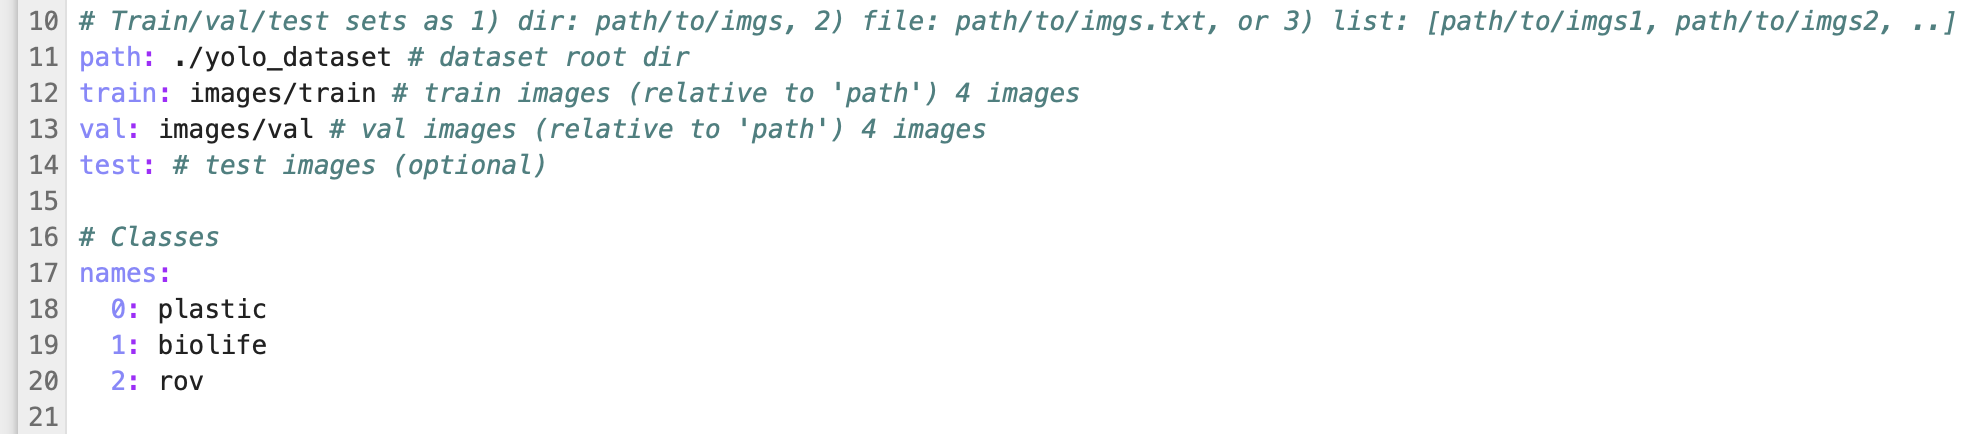


Uploaded the [yaml][1] yaml file and zip archive to Google drive.

[1]: ./custom-model.yaml

### Validation of Trained Model against Unseen Test Data

Post training in Google Colab the model weights are downloaded in local for validation against test images. This way we do not need to keep using GPU as local machine was sufficient to run the validation with test images

In [11]:
# Load the trained model weight
model = YOLO("./yolo-gpu-training1/weights/best.pt")

# Run the evaluation
results = model.val(data="custom-model-val.yaml", conf=0.6, device="mps")


# Print specific metrics
print(results.box.map)  # map50-95
print(results.box.map50)  # map50
print(results.box.map75)  # map75
print("Average precision:", results.box.ap)
print("Average precision at IoU=0.50:", results.box.ap50)
print("F1 score:", results.box.f1)
print("Mean average precision:", results.box.map)
print("Mean average precision at IoU=0.50:", results.box.map50)
print("Mean average precision at IoU=0.75:", results.box.map75)

Ultralytics 8.3.36 🚀 Python-3.12.7 torch-2.5.1 MPS (Apple M2)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /Users/biswajitmac/Documents/Biswajit/github/underwater-plastic-po
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1144       1668      0.964       0.93      0.958      0.816
               plastic        858        937      0.996      0.965      0.982      0.784
               biolife        322        396      0.973      0.917      0.951      0.815
                   rov        258        335      0.924      0.907      0.942      0.847
Speed: 0.3ms preprocess, 10.3ms inference, 0.0ms loss, 9.8ms postprocess per image
Results saved to runs/detect/val
0.8157625237518197
0.9581978983822989
0.9189105330700745
Average precision: [    0.78433     0.81549     0.84747]
Average precision at IoU=0.50: [     0.9815     0.95144     0.94165]
F1 score: [    0.97995     0.94408     0.91566]
Mean average precision: 0.8157625237518197
Mean average precision at IoU=0.50: 0.9581978983822989
Mean average precision at IoU=0.75: 0.9189105330700745


### Display Results for Few Images from Test dataset

Inorder to visualize the results, lest plot grund truth images and predicted bouding boxes.

In [2]:
# Display few images from test directory
image_file_names = []
for files in os.listdir("./yolo_dataset/images/test")[0:10]:
    if (files.split(".")[-1] == "jpg") or (files.split(".")[-1] == "png"):
        # img = cv2.imread(os.path.join("./yolo_dataset/images/test",files))
        # plot_image(img)
        image_file_names.append(files.split(".")[0])

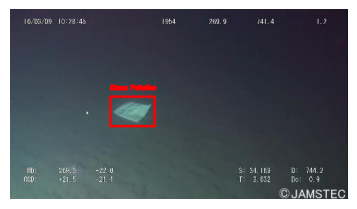

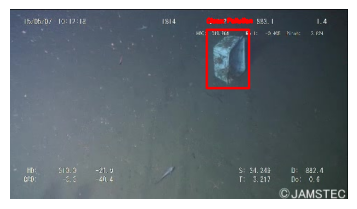

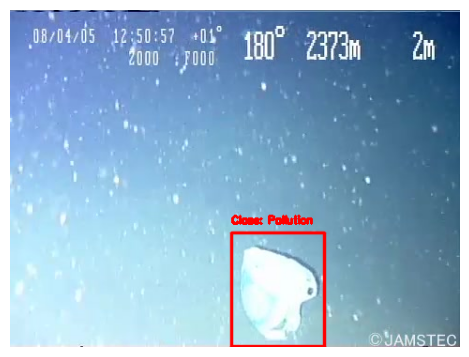

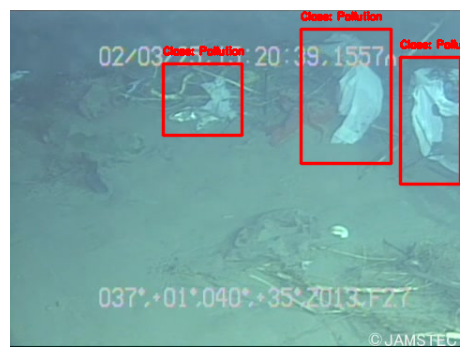

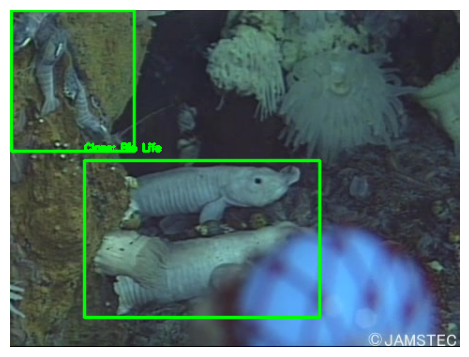

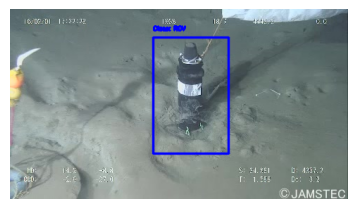

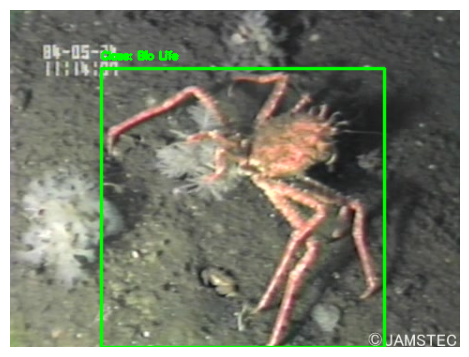

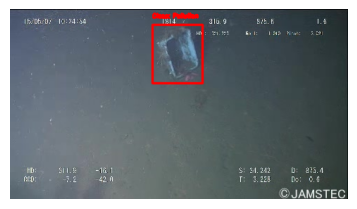

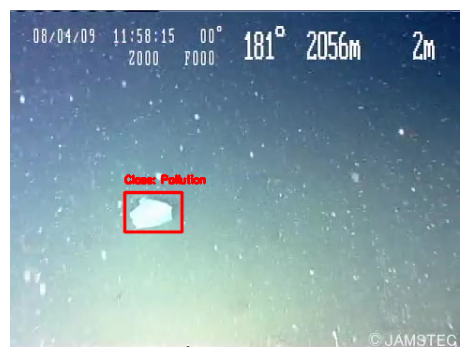

In [5]:
# display images ith ground truth label bounding boxes
class_labels = {0:"Pollution", 1:"Bio Life", 2:"ROV"}
for files in image_file_names:
    img = cv2.imread(os.path.join("./yolo_dataset/images/test",f"{files}.jpg"))
    imgHeight,imgWidth,_ = img.shape
    with open(os.path.join("./yolo_dataset/labels/test",f"{files}.txt"), "r") as label:
        records = label.readlines()
        for record in records:            
            unpacked_list = [float(i) for i in record.split()]
            cls = int(unpacked_list[0])
            xywh_boxes = np.array(unpacked_list[1:])
            xyxy = xywhn2xyxy(xywh_boxes,img.shape[1], img.shape[0])
            xyxy = xyxy.astype("int32")
            # new_boxes = resize_bb([640,640],[imgWidth,imgHeight],[x0,y0],[x1,y1])
            
            color = {0:[0,0,255],1:[0,255,0],2:[255,0,0]}
            cv2.rectangle(img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color[cls], 2, cv2.LINE_AA)
            cv2.putText(img, f"Class: {class_labels[cls]}", (xyxy[0], xyxy[1] - 10),  0, 1e-3 * imgHeight, color[cls], 2)
    plot_image(img)
    
plt.close()

Run inferene with the trained model for the above images and see the results


0: 384x640 1 plastic, 75.2ms
Speed: 1.5ms preprocess, 75.2ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plastic, 70.2ms
Speed: 1.1ms preprocess, 70.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 plastic, 86.8ms
Speed: 1.1ms preprocess, 86.8ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 plastics, 86.4ms
Speed: 1.4ms preprocess, 86.4ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 biolifes, 82.1ms
Speed: 1.1ms preprocess, 82.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 rov, 66.1ms
Speed: 1.2ms preprocess, 66.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 biolife, 82.1ms
Speed: 1.1ms preprocess, 82.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 plastic, 65.0ms
Speed: 0.9ms preprocess, 65.0ms inference, 0.3ms postprocess per image at shape (1,

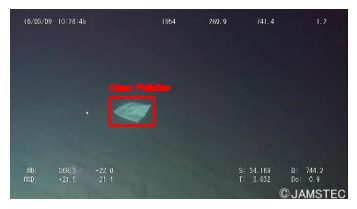

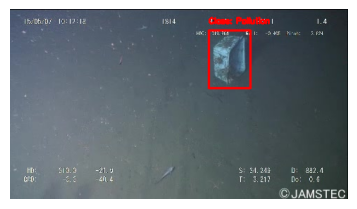

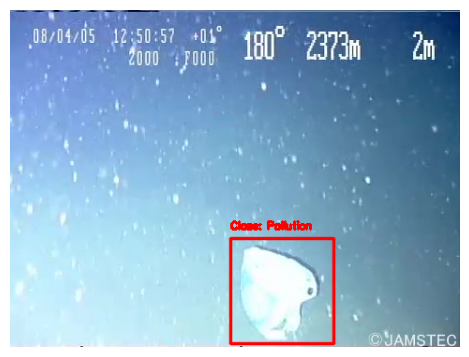

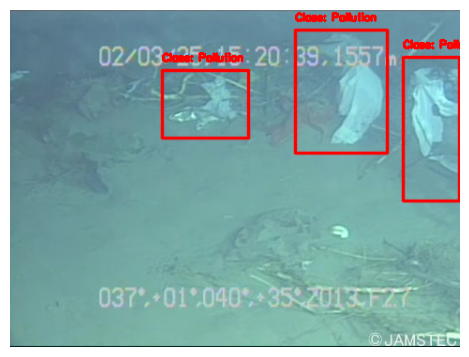

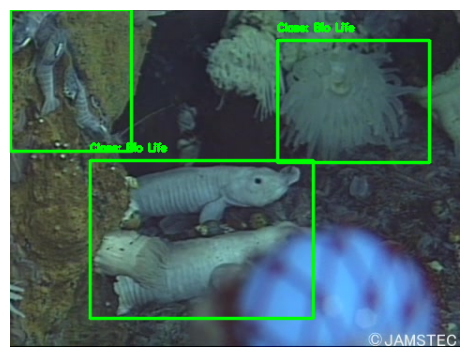

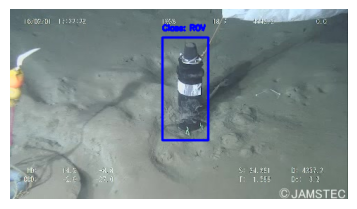

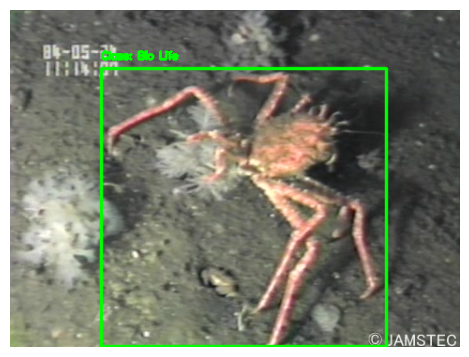

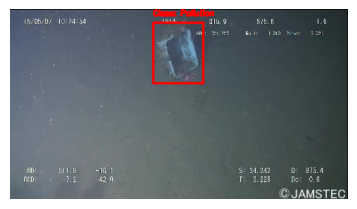

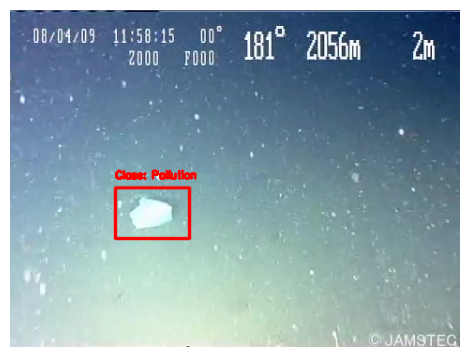

In [6]:
# Run inference on the few images
from ultralytics import YOLO

# Load the trained model
model = YOLO("./yolo-gpu-training1/weights/best.pt")

class_labels = {0:"Pollution", 1:"Bio Life", 2:"ROV"}

for files in image_file_names:
    # print(files)
    img = cv2.imread(os.path.join("./yolo_dataset/images/test",f"{files}.jpg"))
    result = model.predict(img, conf=0.6)
    for r in result:
        # print(type(r))
        boxes = r.boxes
        clsses = boxes.cls.numpy().astype("int32")
        arr = boxes.xyxy.numpy().astype("int32")
        for i in range(arr.shape[0]):
            xyxy = arr[i,:]
            cls = clsses[i]
            # print(cls)
            color = {0:[0,0,255],1:[0,255,0],2:[255,0,0]}
            cv2.rectangle(img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color[cls], 2, cv2.LINE_AA)
            cv2.putText(img, f"Class: {class_labels[cls]}", (xyxy[0], xyxy[1] - 10),  0, 1e-3 * imgHeight, color[cls], 2)
    plot_image(img)
plt.close()
        
        # r.show()  # display to screen

The above images show that the trained model is able to detect plastics and objects very well as present in the ground truth images. It is interesting to notice the trained model even captured the bioife object missed in the 5th original image.